In [1]:
# -------------------------------------------------------------------
# Carga de Datos y Configuración de Conexión
# Conectar a la base de datos MySQL y cargar la vista preparada.
# -------------------------------------------------------------------

import pandas as pd
from sqlalchemy import create_engine
import pymysql # Necesario para el conector, aunque no se use directamente

# Configuración de la conexión a la base de datos Sakila
DB_CONFIG = {
    'user': 'root',   
    'password': 'Qazwsx15487', 
    'host': 'localhost',
    'database': 'sakila'
}

In [2]:
# Crear la cadena de conexión para SQLAlchemy
db_connection_str = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
db_connection = create_engine(db_connection_str)


In [3]:
# Cargar los datos desde la vista SQL
try:
    df = pd.read_sql("SELECT * FROM v_customer_analysis", db_connection)
    print("Datos cargados exitosamente. Primeras 5 filas:")
    print(df.head())
    print("\nInformación del DataFrame:")
    df.info()
except Exception as e:
    print(f"Error al cargar los datos: {e}")
finally:
    db_connection.dispose() # Cierra la conexión


Datos cargados exitosamente. Primeras 5 filas:
   customer_id first_name last_name                                email   
0            1       MARY     SMITH        MARY.SMITH@sakilacustomer.org  \
1            2   PATRICIA   JOHNSON  PATRICIA.JOHNSON@sakilacustomer.org   
2            3      LINDA  WILLIAMS    LINDA.WILLIAMS@sakilacustomer.org   
3            4    BARBARA     JONES     BARBARA.JONES@sakilacustomer.org   
4            5  ELIZABETH     BROWN   ELIZABETH.BROWN@sakilacustomer.org   

   active            address    district            city        country   
0       1     1913 Hanoi Way    Nagasaki          Sasebo          Japan  \
1       1   1121 Loja Avenue  California  San Bernardino  United States   
2       1  692 Joliet Street      Attika         Athenai         Greece   
3       1   1566 Inegl Manor    Mandalay        Myingyan        Myanmar   
4       1    53 Idfu Parkway      Nantou          Nantou         Taiwan   

  customer_since_date  total_spent  total_ren

In [4]:
# -------------------------------------------------------------------
# Análisis Exploratorio de Datos (EDA) Básico
#Entender la distribución de los datos y la variable objetivo.
# -------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Verificar la distribución de la variable objetivo 'is_vip'
print("\nDistribución de clientes VIP:")
print(df['is_vip'].value_counts())
print(df['is_vip'].value_counts(normalize=True))


Distribución de clientes VIP:
is_vip
0    553
1     46
Name: count, dtype: int64
is_vip
0    0.923205
1    0.076795
Name: proportion, dtype: float64


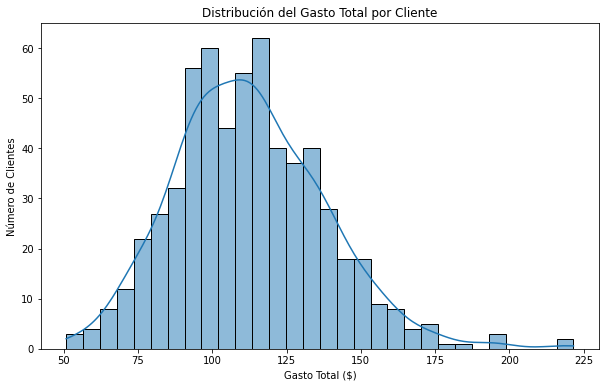

In [5]:
# Visualizar la distribución de 'total_spent'
plt.figure(figsize=(10, 6))
sns.histplot(df['total_spent'], bins=30, kde=True)
plt.title('Distribución del Gasto Total por Cliente')
plt.xlabel('Gasto Total ($)')
plt.ylabel('Número de Clientes')
plt.show()

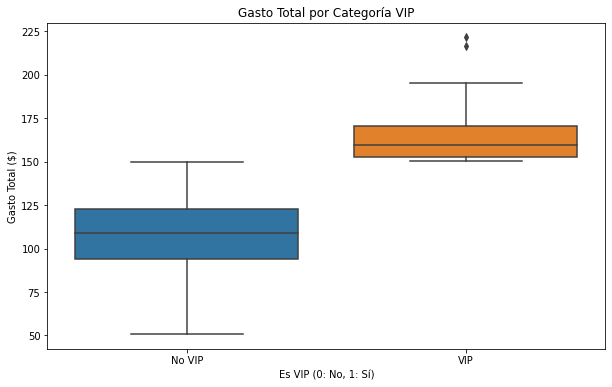

In [6]:

# Comparar el gasto total entre clientes VIP y no VIP
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_vip', y='total_spent', data=df)
plt.title('Gasto Total por Categoría VIP')
plt.xlabel('Es VIP (0: No, 1: Sí)')
plt.ylabel('Gasto Total ($)')
plt.xticks([0, 1], ['No VIP', 'VIP'])
plt.show()

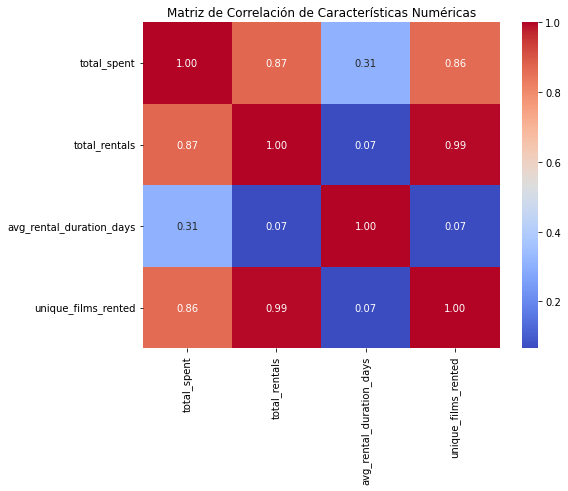

In [7]:
# Correlación entre características numéricas
numeric_cols = ['total_spent', 'total_rentals', 'avg_rental_duration_days', 'unique_films_rented']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Características Numéricas')
plt.show()

In [8]:
# -------------------------------------------------------------------
# Preprocesamiento de Datos
# Preparar las características para el modelo de ML.
# -------------------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Definir características (X) y variable objetivo (y)
# Excluimos 'customer_id', nombres, email y fechas directas que ya convertimos en features
features = [
    'total_spent', 'total_rentals', 'avg_rental_duration_days',
    'unique_films_rented', 'active', 'district', 'city', 'country'
]
target = 'is_vip'

X = df[features]
y = df[target]

# Identificar columnas numéricas y categóricas
numeric_features = ['total_spent', 'total_rentals', 'avg_rental_duration_days', 'unique_films_rented']
categorical_features = ['active', 'district', 'city', 'country']
numeric_features

['total_spent',
 'total_rentals',
 'avg_rental_duration_days',
 'unique_films_rented']

In [9]:
categorical_features

['active', 'district', 'city', 'country']

In [10]:
# Crear transformadores para preprocesamiento
# StandardScaler para numéricas, OneHotEncoder para categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDimensiones de los datos de entrenamiento: {X_train.shape}")
print(f"Dimensiones de los datos de prueba: {X_test.shape}")


Dimensiones de los datos de entrenamiento: (479, 8)
Dimensiones de los datos de prueba: (120, 8)



Entrenando el modelo...
Modelo entrenado.

--- Evaluación del Modelo ---
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       111
           1       0.82      1.00      0.90         9

    accuracy                           0.98       120
   macro avg       0.91      0.99      0.95       120
weighted avg       0.99      0.98      0.98       120


Matriz de Confusión:
[[109   2]
 [  0   9]]

Precisión (Accuracy): 0.9833
ROC AUC Score: 0.9970


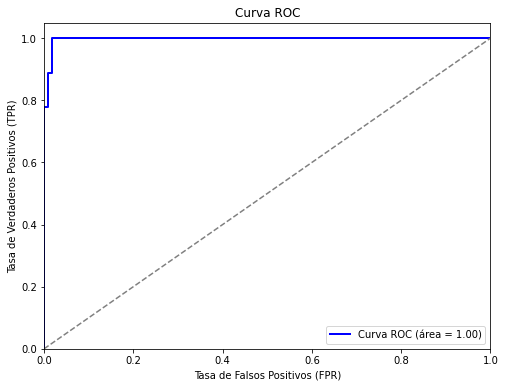

In [35]:
# -------------------------------------------------------------------
# Entrenamiento y Evaluación del Modelo de Machine Learning
# Entrenar un modelo de clasificación y evaluar su rendimiento.
# -------------------------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Crear un pipeline que primero preprocesa y luego entrena el modelo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')) # Usamos class_weight por si hay desbalanceo
])

# Entrenar el modelo
print("\nEntrenando el modelo...")
model_pipeline.fit(X_train, y_train)
print("Modelo entrenado.")

# Realizar predicciones en el conjunto de prueba
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidad de ser VIP

# Evaluación del modelo
print("\n--- Evaluación del Modelo ---")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nPrecisión (Accuracy): {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Una precision de prediccion del 98.33% y la area bajo la curva es de .9970. Por lo que el modelo es bueno

In [36]:
# -------------------------------------------------------------------
# Generación de Predicciones para Visualización
# Obtener predicciones para todo el dataset y guardarlas.
# -------------------------------------------------------------------

# Generar predicciones para el dataset completo
df['predicted_is_vip'] = model_pipeline.predict(X)
df['predicted_vip_proba'] = model_pipeline.predict_proba(X)[:, 1]

# Se puede guardar este DataFrame con las predicciones en un CSV para Power BI
# Aunque para Power BI es mejor conectarse directamente a la DB para la vista.
# df.to_csv('sakila_customer_predictions.csv', index=False)

print("\nPredicciones añadidas al DataFrame original. Primeras filas:")
print(df[['customer_id', 'is_vip', 'predicted_is_vip', 'predicted_vip_proba']].head(40))

print("\nAnálisis de la base de datos y modelado de ML completado.")


Predicciones añadidas al DataFrame original. Primeras filas:
    customer_id  is_vip  predicted_is_vip  predicted_vip_proba
0             1       0                 0             0.008226
1             2       0                 0             0.028479
2             3       0                 0             0.106377
3             4       0                 0             0.000007
4             5       0                 1             0.593803
5             6       0                 0             0.000558
6             7       1                 1             0.937205
7             8       0                 0             0.000078
8             9       0                 0             0.000051
9            10       0                 0             0.002102
10           11       0                 0             0.001007
11           12       0                 0             0.002562
12           13       0                 0             0.025535
13           14       0                 0             0.

In [37]:
Predicciones=df[['customer_id', 'is_vip', 'predicted_is_vip', 'predicted_vip_proba']]
Predicciones

,customer_id,is_vip,predicted_is_vip,predicted_vip_proba
0,1,0,0,0.008226
1,2,0,0,0.028479
2,3,0,0,0.106377
3,4,0,0,0.000007
4,5,0,1,0.593803
...,...,...,...,...
594,595,0,0,0.015034
595,596,0,0,0.000561
596,597,0,0,0.000329
597,598,0,0,0.000096


In [38]:
MayoresPredicciones = Predicciones[Predicciones['predicted_vip_proba']>=0.5]
MayoresPredicciones

,customer_id,is_vip,predicted_is_vip,predicted_vip_proba
4,5,0,1,0.593803
6,7,1,1,0.937205
20,21,1,1,0.957261
25,26,1,1,0.933932
49,50,1,1,0.987283
74,75,1,1,0.970090
118,119,1,1,0.935023
136,137,1,1,0.999811
143,144,1,1,0.999913
147,148,1,1,0.999996


SVM


Entrenando el modelo...
Modelo entrenado.

--- Evaluación del Modelo ---
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       111
           1       1.00      0.78      0.88         9

    accuracy                           0.98       120
   macro avg       0.99      0.89      0.93       120
weighted avg       0.98      0.98      0.98       120


Matriz de Confusión:
[[111   0]
 [  2   7]]

Precisión (Accuracy): 0.9833
ROC AUC Score: 0.9970


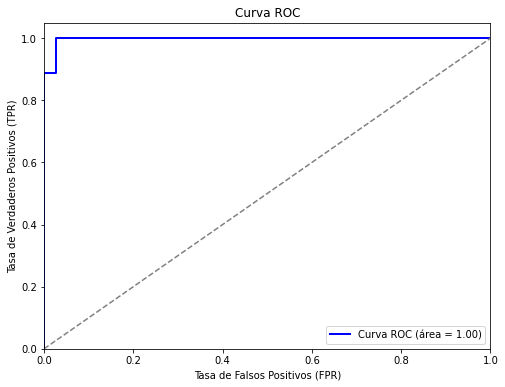

In [52]:
# -------------------------------------------------------------------
# Entrenamiento y Evaluación del Modelo de Machine Learning
# Entrenar un modelo de clasificación y evaluar su rendimiento.
# -------------------------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import SGDClassifier

#svm = SGDClassifier(loss='hinge', class_weight='balanced', random_state= 42)
# Crear un pipeline que primero preprocesa y luego entrena el modelo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',SGDClassifier(loss='log_loss', class_weight='balanced', random_state= 42)) # Usamos class_weight por si hay desbalanceo
])

# Entrenar el modelo
print("\nEntrenando el modelo...")
model_pipeline.fit(X_train, y_train)
print("Modelo entrenado.")

# Realizar predicciones en el conjunto de prueba
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidad de ser VIP

# Evaluación del modelo
print("\n--- Evaluación del Modelo ---")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nPrecisión (Accuracy): {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Tienen los mismos porcentajes de precision y curva roc, Varia la curva roc, en LR la primera clase tiene algunos falsos negativos, en cambio SVM tiene estos falsos negativos en la segunda clase. 

In [53]:
# -------------------------------------------------------------------
# Generación de Predicciones para Visualización
# Obtener predicciones para todo el dataset y guardarlas.
# -------------------------------------------------------------------

# Generar predicciones para el dataset completo
df['predicted_is_vip'] = model_pipeline.predict(X)
df['predicted_vip_proba'] = model_pipeline.predict_proba(X)[:, 1]

# Se puede guardar este DataFrame con las predicciones en un CSV para Power BI
# Aunque para Power BI es mejor conectarse directamente a la DB para la vista.
# df.to_csv('sakila_customer_predictions.csv', index=False)

print("\nPredicciones añadidas al DataFrame original. Primeras filas:")
print(df[['customer_id', 'is_vip', 'predicted_is_vip', 'predicted_vip_proba']].head(40))

print("\nAnálisis de la base de datos y modelado de ML completado.")



Predicciones añadidas al DataFrame original. Primeras filas:
    customer_id  is_vip  predicted_is_vip  predicted_vip_proba
0             1       0                 0         2.935921e-17
1             2       0                 0         3.973622e-13
2             3       0                 0         1.072257e-09
3             4       0                 0         3.401769e-35
4             5       0                 0         1.603969e-04
5             6       0                 0         3.549053e-26
6             7       1                 1         9.976545e-01
7             8       0                 0         7.842711e-29
8             9       0                 0         3.891221e-30
9            10       0                 0         1.707034e-22
10           11       0                 0         2.443541e-23
11           12       0                 0         7.045236e-22
12           13       0                 0         5.332179e-10
13           14       0                 0         6.4579

In [54]:

# -------------------------------------------------------------------
# Guardar Predicciones en la Base de Datos
# Persistir las predicciones del modelo en una nueva tabla SQL.
# -------------------------------------------------------------------

import sqlalchemy
import pymysql # Asegúrate de que pymysql esté instalado para la conexión MySQL

# Recrear la conexión a la base de datos para asegurar que esté abierta
db_connection_str = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
db_connection = create_engine(db_connection_str)

# Preparar un DataFrame solo con las IDs de cliente y las predicciones
df_predictions = df[['customer_id', 'predicted_is_vip', 'predicted_vip_proba']].copy()

# Opcional: Asegurarse de que los tipos de datos sean compatibles con MySQL
# 'predicted_is_vip' es un int (0 o 1)
# 'predicted_vip_proba' es un float (0.0 a 1.0)

# Nombre de la tabla donde guardaremos las predicciones
predictions_table_name = 'customer_ml_predictions'

print(f"\nGuardando predicciones en la tabla '{predictions_table_name}' en MySQL...")

try:
    # Eliminar la tabla si ya existe (para asegurar que siempre sea una tabla nueva)
    with db_connection.connect() as conn:
        conn.execute(sqlalchemy.text(f"DROP TABLE IF EXISTS {predictions_table_name};"))
        conn.commit() # Asegura que el DROP se ejecute antes del to_sql

    # Guardar el DataFrame en MySQL
    # if_exists='replace' recrea la tabla cada vez, útil para desarrollo
    # index=False para no guardar el índice de Pandas como una columna
    df_predictions.to_sql(name=predictions_table_name, con=db_connection, if_exists='replace', index=False)

    # Opcional: Añadir un índice en customer_id para optimizar JOINs futuros
    with db_connection.connect() as conn:
        conn.execute(sqlalchemy.text(f"CREATE INDEX idx_customer_id ON {predictions_table_name} (customer_id);"))
        conn.commit()
    print(f"Predicciones guardadas exitosamente en la tabla '{predictions_table_name}'.")

except Exception as e:
    print(f"Error al guardar las predicciones en la base de datos: {e}")
finally:
    db_connection.dispose()

print("\nProceso de guardado de predicciones completado.")


Guardando predicciones en la tabla 'customer_ml_predictions' en MySQL...
Predicciones guardadas exitosamente en la tabla 'customer_ml_predictions'.

Proceso de guardado de predicciones completado.


In [55]:
Predicciones2=df[['customer_id', 'is_vip', 'predicted_is_vip', 'predicted_vip_proba']]
Predicciones2

,customer_id,is_vip,predicted_is_vip,predicted_vip_proba
0,1,0,0,2.935921e-17
1,2,0,0,3.973622e-13
2,3,0,0,1.072257e-09
3,4,0,0,3.401769e-35
4,5,0,0,1.603969e-04
...,...,...,...,...
594,595,0,0,1.252895e-14
595,596,0,0,5.521512e-25
596,597,0,0,1.420246e-25
597,598,0,0,5.271858e-30


In [59]:
Predicciones2=Predicciones2.rename(columns={'predicted_is_vip': 'Prediccion VIP'})
Predicciones2=Predicciones2.rename(columns={'predicted_vip_proba': 'Probabilidad VIP'})
Predicciones2

,customer_id,is_vip,Prediccion VIP,Probabilidad VIP
0,1,0,0,2.935921e-17
1,2,0,0,3.973622e-13
2,3,0,0,1.072257e-09
3,4,0,0,3.401769e-35
4,5,0,0,1.603969e-04
...,...,...,...,...
594,595,0,0,1.252895e-14
595,596,0,0,5.521512e-25
596,597,0,0,1.420246e-25
597,598,0,0,5.271858e-30


In [60]:
# sakila_ml_modeling.ipynb -

# -------------------------------------------------------------------
# (Alternativa): Guardar Predicciones en CSV
# Objetivo: Exportar el DataFrame con predicciones a un archivo CSV.
# -------------------------------------------------------------------

# Asegúrate de que 'df' ya contenga las columnas 'predicted_is_vip' y 'predicted_vip_proba'


output_csv_path = 'sakila_customer_predictions.csv'
Predicciones2.to_csv(output_csv_path, index=False)

print(f"\nDataFrame con predicciones guardado en: {output_csv_path}")


DataFrame con predicciones guardado en: sakila_customer_predictions.csv


In [45]:
MayoresPredicciones2 = Predicciones2[Predicciones2['predicted_vip_proba']>=0.5]
MayoresPredicciones2

,customer_id,is_vip,predicted_is_vip,predicted_vip_proba
6,7,1,1,0.997655
20,21,1,1,0.999970
25,26,1,1,0.999998
49,50,1,1,1.000000
74,75,1,1,0.999970
118,119,1,1,1.000000
136,137,1,1,1.000000
143,144,1,1,1.000000
147,148,1,1,1.000000
175,176,1,1,1.000000


In [51]:
Predicciones2_1 = Predicciones2[Predicciones2['is_vip']>=1]
Predicciones2_1

,customer_id,is_vip,predicted_is_vip,predicted_vip_proba
6,7,1,1,0.997655
20,21,1,1,0.999970
25,26,1,1,0.999998
49,50,1,1,1.000000
74,75,1,1,0.999970
118,119,1,1,1.000000
136,137,1,1,1.000000
143,144,1,1,1.000000
147,148,1,1,1.000000
175,176,1,1,1.000000
